In [1]:
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.optimizers import Adam
from sklearn.datasets import load_iris
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

import sys

from core.data_selector import DataSelector

import matplotlib.pyplot as plt
import random

In [2]:
# Fijar semillas
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# 1. Data set Iris

In [3]:
# Cargar datos
data_iris = load_iris()

X_ = data_iris['data']
y_ = data_iris['target']

# One hot encoding
enc = OneHotEncoder(sparse_output=False)
y_ = y_.reshape(-1, 1)
target = enc.fit_transform(y_)

# Dividir en train y test
X_train, X_val, y_train, y_val = train_test_split(X_, target, test_size=0.4, random_state=0)


print("Inputs Shape: ", X_train.shape, X_val.shape)
print("Targets Shape: ", y_train.shape, y_val.shape)

Inputs Shape:  (90, 4) (60, 4)
Targets Shape:  (90, 3) (60, 3)


## 2. Model

In [4]:
# Crear modelo
class CustomModel(tf.keras.Model):
    def __init__(self, D_in, H1, H2, D_out):
        super(CustomModel, self).__init__()
        self.cl1 = tf.keras.layers.Dense(H1, activation='relu', input_shape=(D_in,))
        self.cl2 = tf.keras.layers.Dense(H1, activation='relu')
        self.cl3 = tf.keras.layers.Dense(H2, activation='relu')
        self.fc1 = tf.keras.layers.Dense(D_out, activation='softmax')

    def call(self, inputs):
        x = self.cl1(inputs)
        x = self.cl2(x)
        x = self.cl3(x)
        x = self.fc1(x)
        return x

    def inspector_out(self, inputs):
        x = self.cl1(inputs)
        x = self.cl2(x)
        x = self.cl3(x)
        return x

# Instanciar el modelo
model_iris = CustomModel(4, 20, 20, 3)

## 3. Primera fase de entrenamiento: sin Filtrado

In [5]:
# Configuración del entrenamiento
learning_rate = 0.001
adam_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
model_iris.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Configuración del Early Stopping
early_stopping = EarlyStopping(monitor='val_accuracy',      # Monitorea el accuracy de validación
                               patience=20,                 # Número de épocas sin mejora después de las cuales el entrenamiento será detenido
                               verbose=1,                   # Muestra mensajes al detener
                               mode='max',                  # Detiene el entrenamiento cuando el valor monitoreado deja de aumentar
                               restore_best_weights=True)   # Restaura los pesos del modelo al mejor valor encontrado

In [6]:
# Entrenamiento
model_iris.fit(X_train, y_train, epochs=3000, batch_size=32, verbose = 0, validation_data=(X_val, y_val), callbacks=[early_stopping])

Restoring model weights from the end of the best epoch: 4.
Epoch 24: early stopping


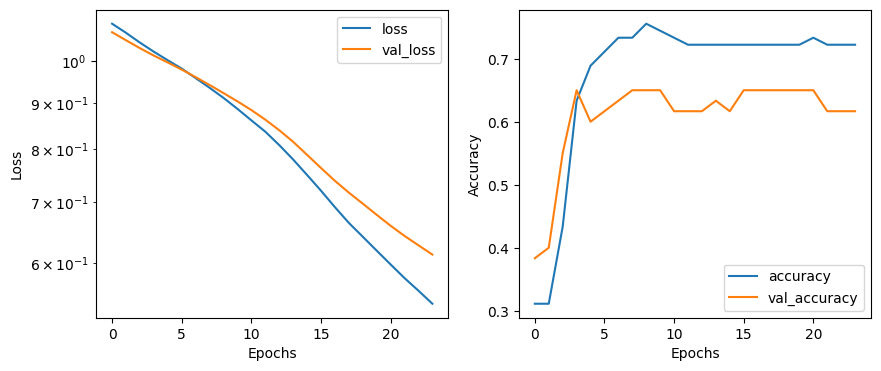

In [7]:
# Resultados
plt.figure(figsize=(10, 4))

# Gráfica Loss
plt.subplot(1, 2, 1)
plt.plot(model_iris.history.history['loss'], label='loss')
plt.plot(model_iris.history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

# Gráfica Accuracy
plt.subplot(1, 2, 2)
plt.plot(model_iris.history.history['accuracy'], label='accuracy')
plt.plot(model_iris.history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [8]:
# Evalaución para los mejores pesos para el modelo
loss_train, accuracy_train = model_iris.evaluate(X_train, y_train, verbose=0)
loss_val, accuracy_val = model_iris.evaluate(X_val, y_val, verbose=0)
print(f"Train loss: {loss_train}")
print(f"Train accuracy: {accuracy_train}")
print(f"Validation loss: {loss_val}")
print(f"Validation accuracy: {accuracy_val}")

Train loss: 1.0080716609954834
Train accuracy: 0.6666666865348816
Validation loss: 1.0138461589813232
Validation accuracy: 0.6499999761581421


## 4. Segunda fase de entrenamiento: con Filtrado

In [9]:
epochs = 20                    # Número de épocas
epoch_init_filter = 1          # Época en la que se inicia el filtro
update_period_in_epochs = 5    # Período de actualización en épocas

In [10]:
# Instanciar selector de datos
data_selector = DataSelector(X_train, y_train, epoch_init_filter , update_period_in_epochs, filter_percentile=0.25, random_state=280296, train_with_outliers=False)

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Configura el callback para guardar los mejores pesos
checkpoint_filepath = 'model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [12]:
# Diccionario para almacenar la información del entrenamiento
train_info = {
    'train_losses': [],
    'val_losses': [],
    'train_accuracies': [],
    'val_accuracies': []
}

In [13]:
# Loop de entrenamiento
for epoch in range(epochs):
    # Obtener conjuntos de entrenamiento filtrados
    X_tr_filtered, y_tr_filtered, all_removed_indices = data_selector.get_train_data(epoch=epoch, model=model_iris, outs_posibilities=list(np.unique(y_)))

    # Entrenar el modelo
    history = model_iris.fit(X_tr_filtered, y_tr_filtered, epochs=1, batch_size=32, verbose=0, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback] )

    # Almacenar la información del entrenamiento
    train_info['train_losses'].append(history.history['loss'])
    train_info['val_losses'].append(history.history['val_loss'])
    train_info['train_accuracies'].append(history.history['accuracy'])
    train_info['val_accuracies'].append(history.history['val_accuracy'])

    print(f"Epoch: {epoch+1}")


Epoch 1: val_accuracy improved from -inf to 0.65000, saving model to model_checkpoint.h5
Epoch: 1
Initial PCA components: 1 for 95.0% variance explained
PCA DONE with 1 components
Size of the training set: 90
GMM-associated clusters to real class: {1: 0, 2: 1, 0: 2}
All clases have just one cluster associated
Remove data: [2, 6, 8, 12, 13, 14, 16, 19, 27, 29, 34, 41, 53, 58, 59, 60, 71, 72, 73, 77, 79, 81, 83]
Data has been filtered
Size of data removed: 23

Epoch 1: val_accuracy did not improve from 0.65000
Epoch: 2

Epoch 1: val_accuracy improved from 0.65000 to 0.75000, saving model to model_checkpoint.h5
Epoch: 3

Epoch 1: val_accuracy improved from 0.75000 to 0.86667, saving model to model_checkpoint.h5
Epoch: 4

Epoch 1: val_accuracy did not improve from 0.86667
Epoch: 5

Epoch 1: val_accuracy did not improve from 0.86667
Epoch: 6
Initial PCA components: 1 for 95.0% variance explained
PCA DONE with 1 components
Size of the training set: 67
GMM-associated clusters to real class: 

In [14]:
print(f'Initial sets training: {X_train.shape[0]}')
print(f'Final sets training: {X_tr_filtered.shape[0]}')


Initial sets training: 90
Final sets training: 27


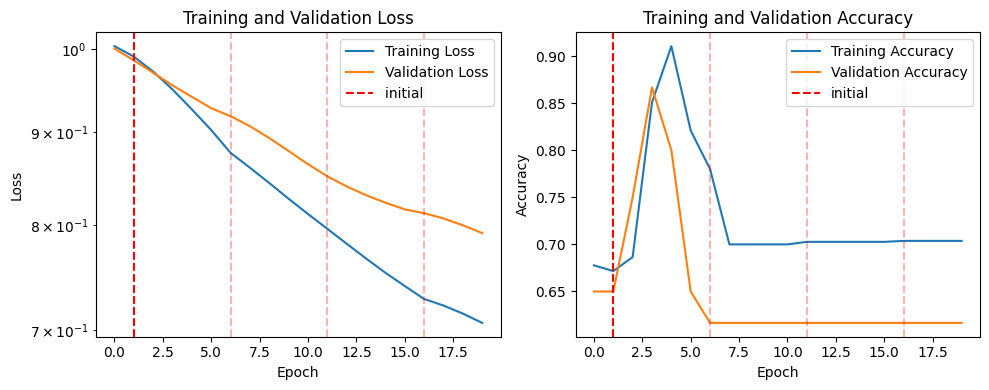

In [15]:
import matplotlib.pyplot as plt

# Graficar la pérdida de entrenamiento y validación
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_info['train_losses'], label='Training Loss')
plt.plot(train_info['val_losses'], label='Validation Loss')
plt.axvline(x=epoch_init_filter, color='r', linestyle='--', label='initial ')
for i in range(epoch_init_filter, epochs + 1, update_period_in_epochs):
    plt.axvline(x=i, color='r', linestyle='--', alpha=0.3)  # Líneas cada 5 epochs
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()

# Graficar la exactitud de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(train_info['train_accuracies'], label='Training Accuracy')
plt.plot(train_info['val_accuracies'], label='Validation Accuracy')
plt.axvline(x=epoch_init_filter, color='r', linestyle='--', label='initial')
for i in range(epoch_init_filter, epochs + 1, update_period_in_epochs):
    plt.axvline(x=i, color='r', linestyle='--', alpha=0.3)  # Líneas cada 5 epochs
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Cargar mejores pesos
model_iris.load_weights(checkpoint_filepath)

# Evalaución Accuracy
loss_train, accuracy_train = model_iris.evaluate(X_tr_filtered, y_tr_filtered, verbose=0)
loss_val, accuracy_val = model_iris.evaluate(X_val, y_val, verbose=0)
print(f"Training loss: {loss_train}")
print(f"Training accuracy: {accuracy_train}")
print(f"Validation loss: {loss_val}")
print(f"Validation accuracy: {accuracy_val}")


Training loss: 0.9328590035438538
Training accuracy: 0.9629629850387573
Validation loss: 0.9552195072174072
Validation accuracy: 0.8666666746139526


In [17]:
print(all_removed_indices)

[2, 6, 8, 12, 13, 14, 16, 19, 27, 29, 34, 41, 53, 58, 59, 60, 71, 72, 73, 77, 79, 81, 83, 0, 33, 34, 64, 5, 37, 43, 46, 16, 18, 20, 21, 53, 54, 25, 62, 63, 1, 37, 39, 40, 11, 14, 16, 17, 48, 19, 22, 24, 26, 0, 2, 3, 13, 19, 23, 24, 27, 28, 30]
